In [1]:
# general
import sys, os, path

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans/scripts/')
import barymap as bm

# standard datatype
dtype = torch.double

In [2]:
class TBNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TBNN, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
        self.hidden_layer_1 = torch.nn.Linear(H, H)
        self.hidden_layer_2 = torch.nn.Linear(H, H)
        self.hidden_layer_3 = torch.nn.Linear(H, H)
        self.hidden_layer_4 = torch.nn.Linear(H, int(H/2))
        self.hidden_layer_5 = torch.nn.Linear(int(H/2), int(H/4))
        self.hidden_layer_6 = torch.nn.Linear(int(H/4), int(H/8))
        self.output_linear = torch.nn.Linear(int(H/8), D_out)
        self.NN = torch.nn.Sequential(self.input_layer,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_1,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_2,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_3,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_4,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_5,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_6,
                                      torch.nn.LeakyReLU(),
                                      self.output_linear)
        
    def forward(self, inv, T):
        G = self.NN(inv)
        G0 = G.unsqueeze(2).expand(inv.shape[0],10,9)
        return (G0*T).sum(dim=1), G

In [3]:
# set path to models and initialise arrays
model_path = 'trained_models/'
model_names = os.listdir(model_path)
print(model_names)
models = []
train_loss = []
val_loss = []

# loop over model names
for i, name in enumerate(model_names):
    models.append(th.load(os.sep.join([model_path, name, 'model.pt'])))
    models[i].eval()  # mandatory, see torch.load doc
    train_loss.append(th.load(os.sep.join([model_path, name, 'loss_vector.th'])))
    val_loss.append(th.load(os.sep.join([model_path, name, 'val_loss_vector.th'])))

['3cases', '4cases']


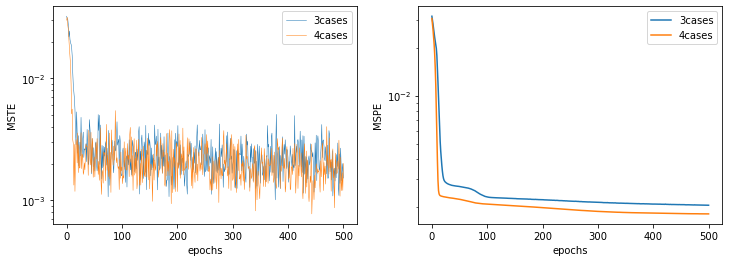

In [4]:
# plot training and validiation error of models
fig, ax = plt.subplots(1,2, figsize=(12,4))

for i,_ in enumerate(train_loss):
    ax[0].semilogy(np.arange(train_loss[i].shape[0]), train_loss[i], linewidth=0.5)
    ax[0].set_xlabel(r'epochs')
    ax[0].set_ylabel(r'MSTE')

    ax[1].semilogy(np.arange(val_loss[i].shape[0]), val_loss[i])
    ax[1].set_xlabel(r'epochs')
    ax[1].set_ylabel(r'MSPE')
    
ax[0].legend(model_names)
ax[1].legend(model_names)

In [5]:
# load in flowcase for testing
test_data_path =  '/home/leonriccius/Documents/Fluid_Data/test_data/periodic_hills/tensordata'
# on workstation: /home/leon/Master_Thesis/Fluid_Data ...
cases = '2800'
curr_case = os.sep.join([test_data_path, cases])

# read in test case tensors
inv_test = th.load(os.sep.join([curr_case,'inv-torch.th']))
T_test = th.load(os.sep.join([curr_case,'T-torch.th'])).reshape(-1,10,9)
b_test = th.load(os.sep.join([curr_case,'b-torch.th']))
grid_test = th.load(os.sep.join([curr_case,'grid-torch.th']))

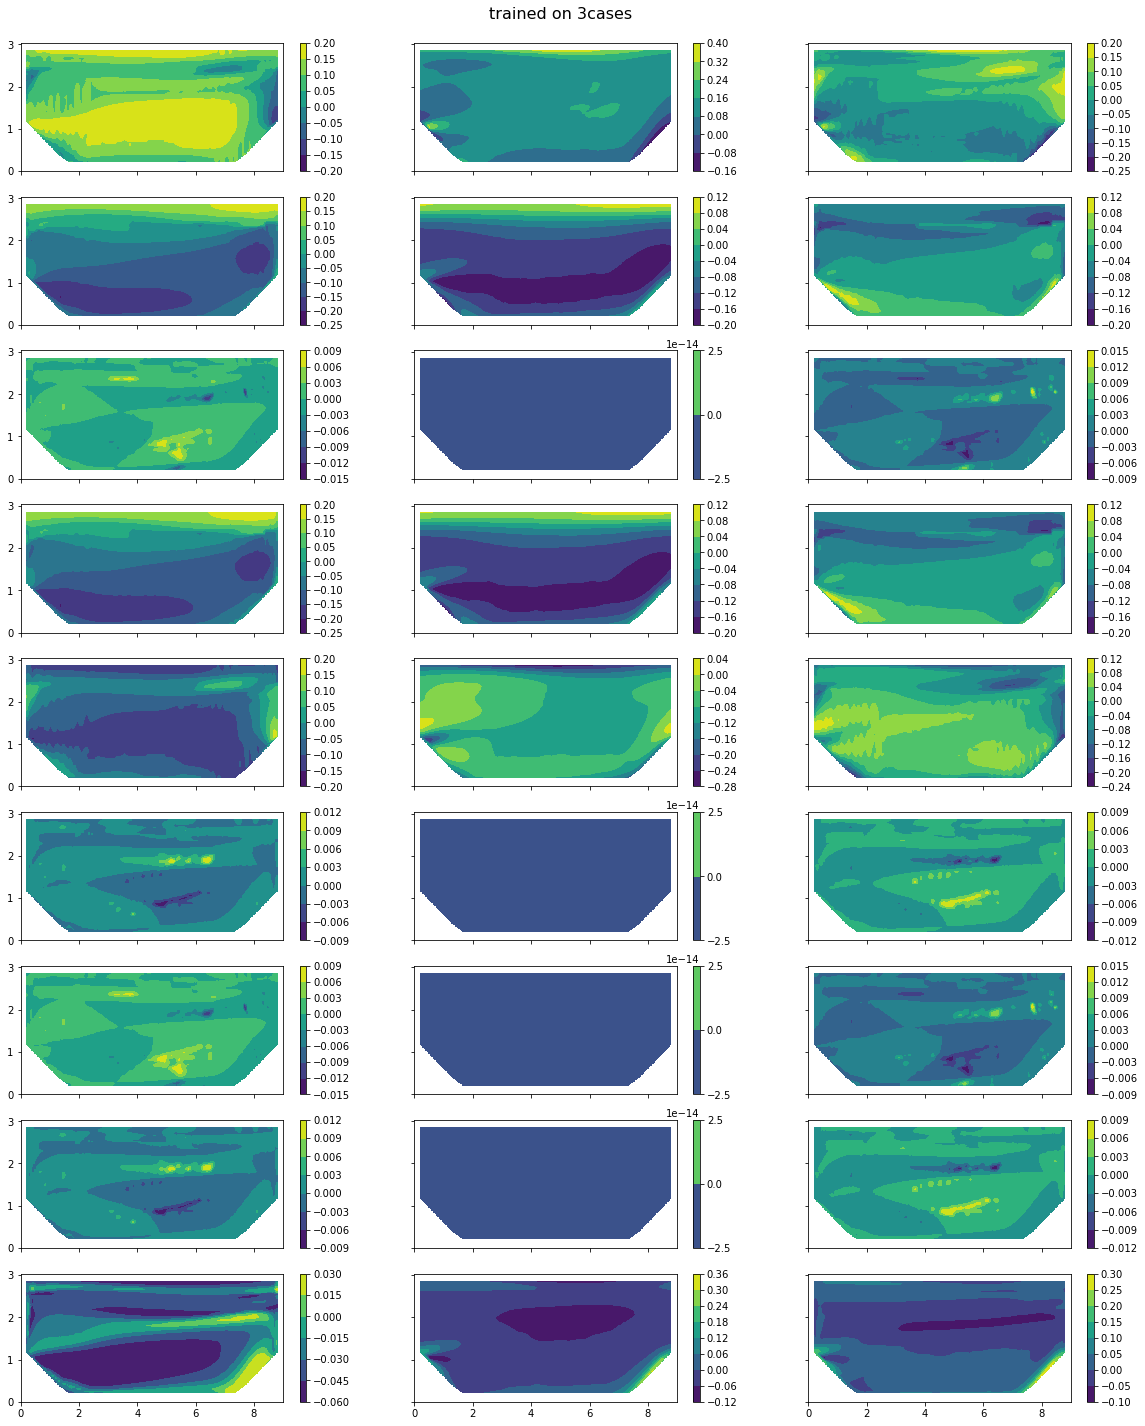

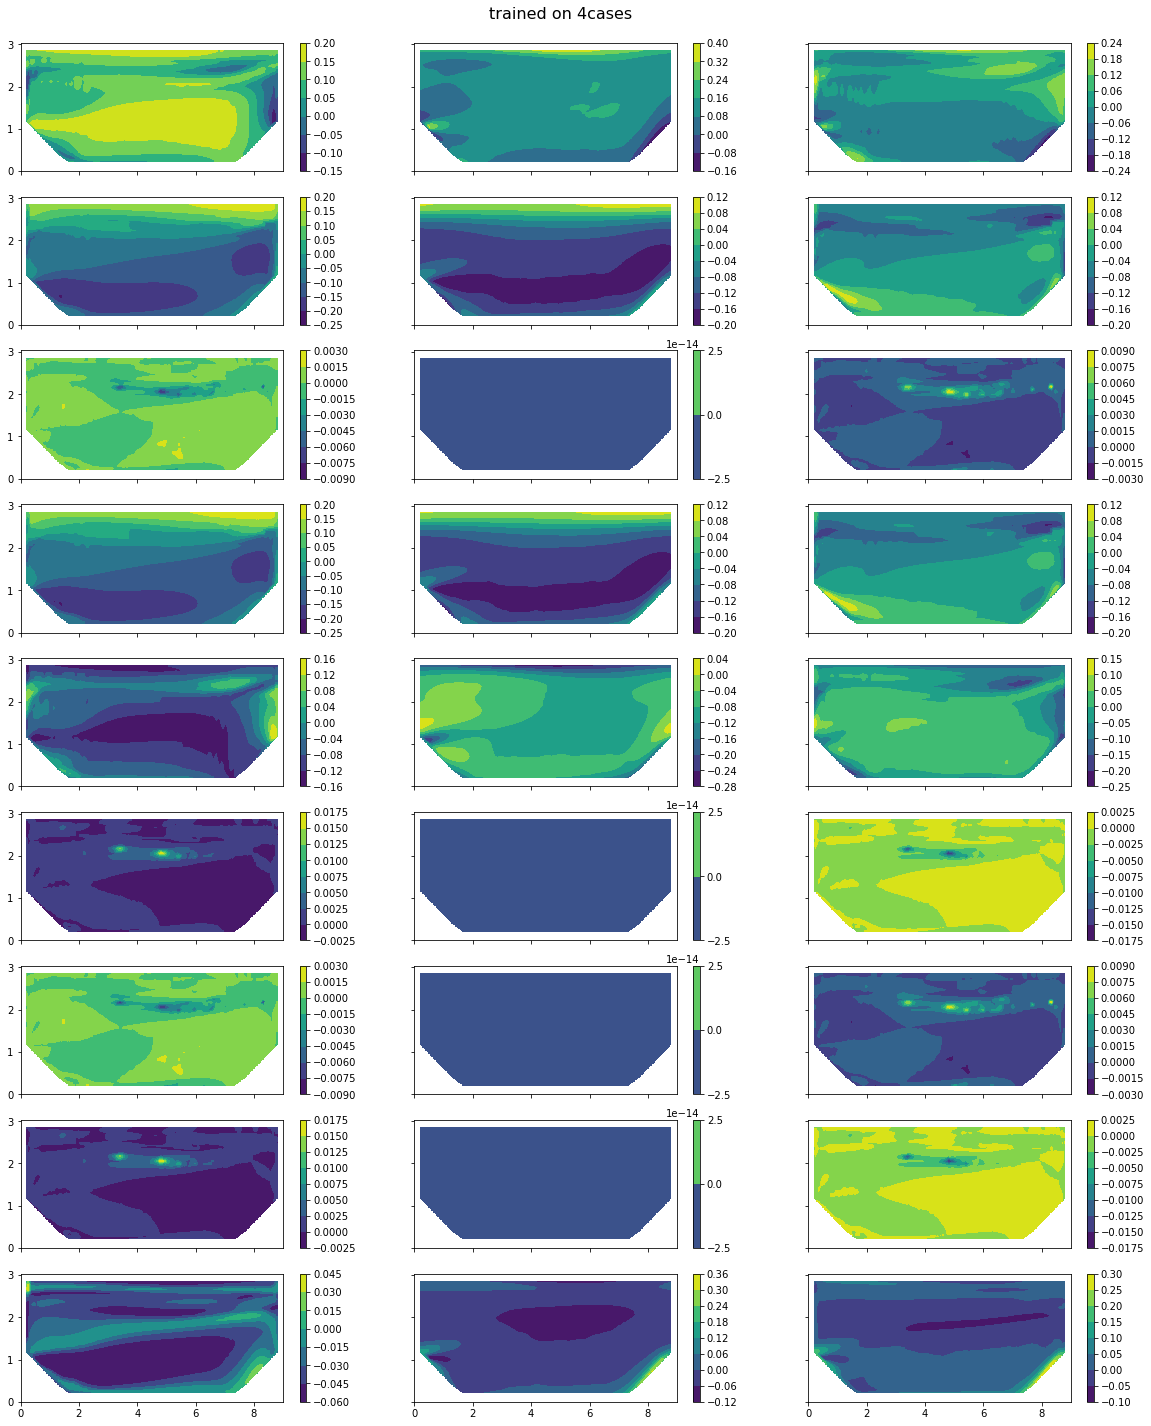

In [6]:
# predicts b for all models and plot the components
# grid for visualisation
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

for i, model in enumerate(models):
    
    # get predicted b
    b_pred, _ = model(inv_test, T_test) # .reshape(-1,9)
    
    # create figure
    fig, axs = plt.subplots(9,3, figsize=(20,25), sharex=True, sharey=True)
    
    # loop over all 9 components of b, for pred of b, real b, and difference of these two
    for j in range(9):
        grid_b_pred = griddata(grid_test, b_pred.flatten(1).detach().numpy()[:,j], (grid_x, grid_y), method='linear')
        grid_b_test = griddata(grid_test, b_test.flatten(1).detach().numpy()[:,j], (grid_x, grid_y), method='linear')
        grid_b_diff = grid_b_test - grid_b_pred
        b_nn = axs.flat[3*j].contourf(grid_x, grid_y, grid_b_pred)
        b_dns = axs.flat[3*j+1].contourf(grid_x, grid_y, grid_b_test)
        b_diff = axs.flat[3*j+2].contourf(grid_x, grid_y, grid_b_diff)
        fig.colorbar(b_nn, ax=axs.flat[3*j])
        fig.colorbar(b_dns, ax=axs.flat[3*j+1])
        fig.colorbar(b_diff, ax=axs.flat[3*j+2])
    
    fig.suptitle('trained on ' + model_names[i], y=0.9, fontsize=16)

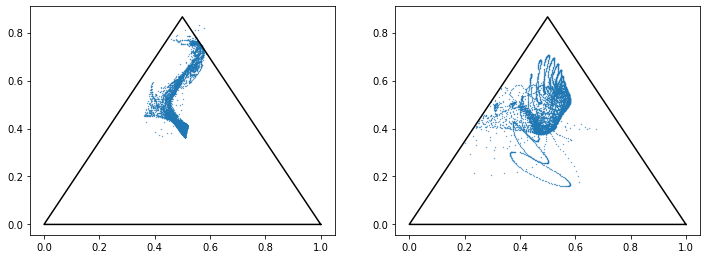

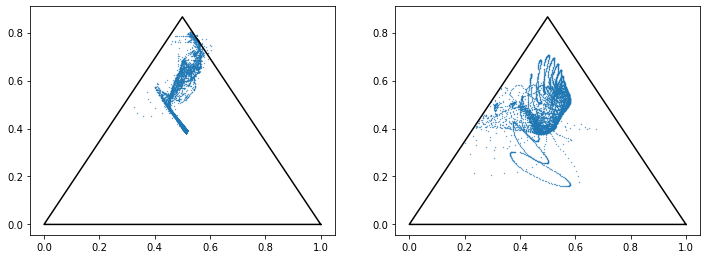

In [7]:
# get barycentric map for models

#loop over models
for i, model in enumerate(models):
    fig, ax = plt.subplots(1,2, figsize=(12,4.2))
    
    #get prediction and plot the datapoints
    b_pred, _ = model(inv_test, T_test)
    barm_pred = bm.BarMap()
    barm_pred.load_from_variable(b_pred.reshape(-1,3,3).detach().numpy(), grid_test)
    barm_pred.calculate_barycentric_coordinates()
    barm_pred.plot_data_points(ax[0])
    barm_pred.plot_triangle(ax[0])
    
    # plot the dns data points
    barm = bm.BarMap()
    barm.load_from_variable(b_test.reshape(-1,3,3).detach().numpy(), grid_test)
    barm.calculate_barycentric_coordinates()
    barm.plot_data_points(ax[1])
    barm.plot_triangle(ax[1])